In [1]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
import numpy as np
import scipy.stats as stats
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

from theano import shared

In [3]:
plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

In [4]:
size = 200
w0 = 1
w1 = 2
sigma = .5
x = np.linspace(0,1,size)
regression_line = w0+w1*x
y = regression_line + np.random.normal(scale=sigma, size= size)
data = dict(x=x, y=y)
x_shared = shared(x)

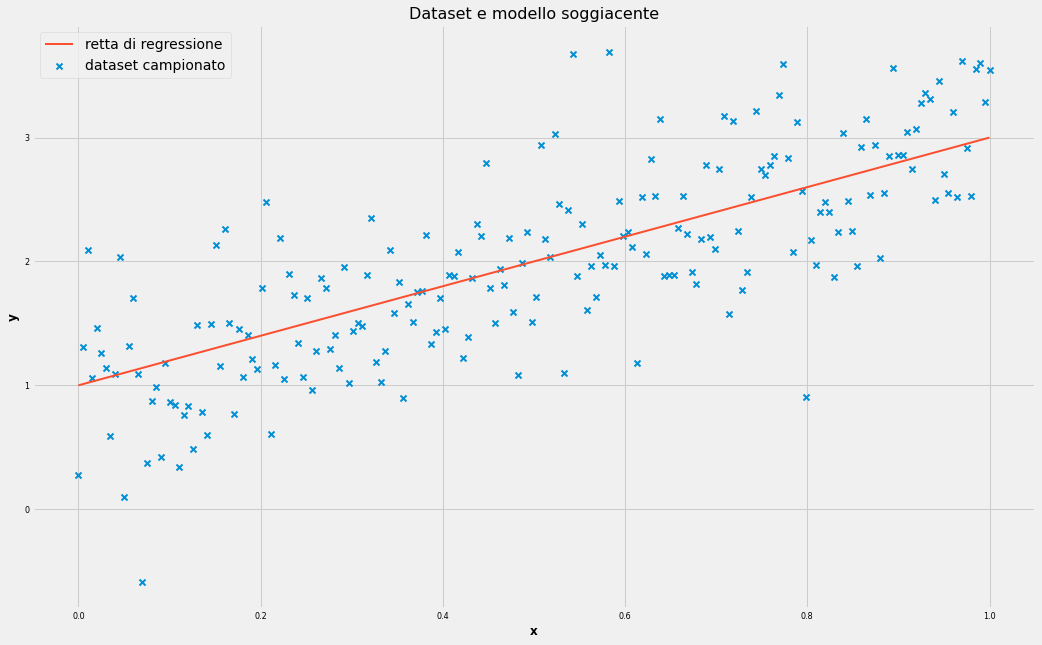

In [5]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
ax.scatter(x, y, marker='x', color=colors[0],label='dataset campionato')
ax.plot(x, regression_line, color=colors[1], label='retta di regressione', lw=2.)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Dataset e modello soggiacente', fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.show()

### Modello bayesiano gerarchico utilizzato

![Diagramma modello regressione lineare gaussiana.](assets/lin_regr.png)

$t_i$ viene assunto avere distribuzione gaussiana con valore atteso $\theta^T\overline{x}_i$ e deviazione standard $\sigma$. I coefficienti in $\theta$ si assumono estratti da una distribuzione gaussiana di media $M$ e deviazione standard $S$. $\sigma$ si assume invece estratto da una distribuzione esponenziale con parametro $L$

In [6]:
M = 0
S = 20
L = 1

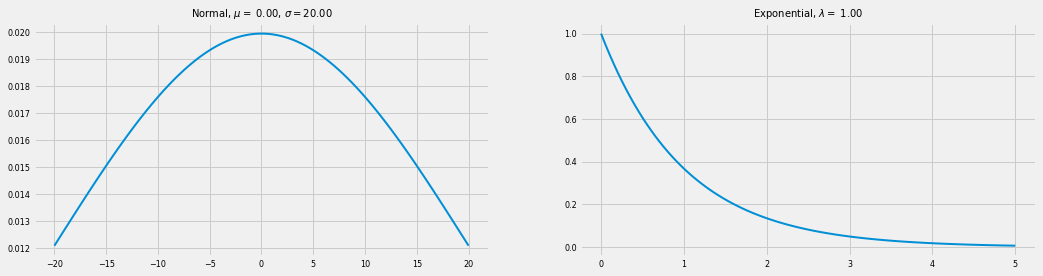

In [7]:
fig = plt.figure(figsize=(16, 4))
dist = stats.norm(loc=M, scale=S)
ax = fig.add_subplot(121)
xx = np.linspace(-20,20, 100)
ax.plot(xx, dist.pdf(xx))
plt.title('Normal, $\mu=${0:5.2f}, $\sigma=${1:5.2f}'.format(M,S))
ax = fig.add_subplot(122)
dist1 = stats.expon(scale=1.0/L)
xx = np.linspace(0,5, 100)
ax.plot(xx, dist1.pdf(xx))
plt.title('Exponential, $\lambda=${0:5.2f}'.format(1.0/L))
plt.show()

Definizione del modello in Pymc3

In [8]:
with pm.Model() as model:
    # distribuzioni variabili random originali nel modello
    sigma = pm.Exponential('sigma', lam=L)
    theta_0 = pm.Normal('theta_0', mu=M, sd=S)
    theta_1 = pm.Normal('theta_1', mu=M, sd=S)
    # distribuzione della variabile random di output, di cui si osservano le instanziazioni nei dati
    y = pm.Normal('y', mu=theta_0+theta_1*x_shared, sd=sigma, observed=data['y'])

Sampling

In [9]:
trace = pm.sample(draws=5000, model=model, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_1, theta_0, sigma]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 32 seconds.


In [10]:
pm.save_trace(trace, 'linregr.trace', overwrite=True)
#with model:
#  trace = pm.load_trace('linregr.trace') 

<Figure size 1152x576 with 0 Axes>

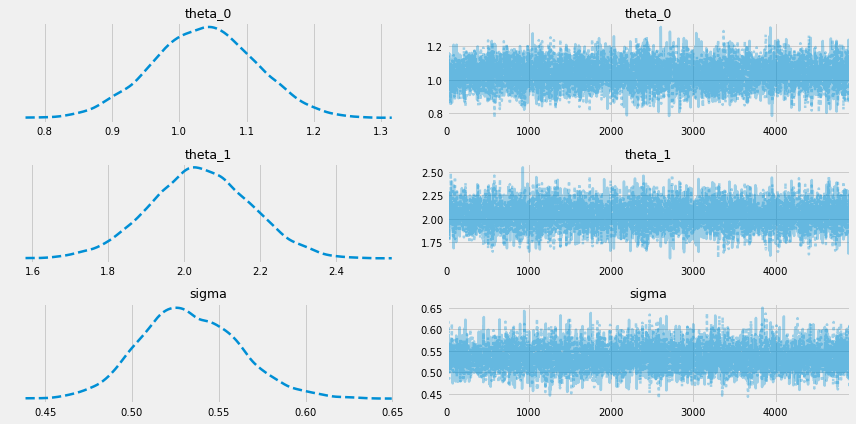

In [13]:
plt.figure(figsize=(16,8))
az.plot_trace(trace[100:], lines={'theta_0':w0, 'theta_1':w1}, combined=True)
plt.tight_layout()
plt.show()

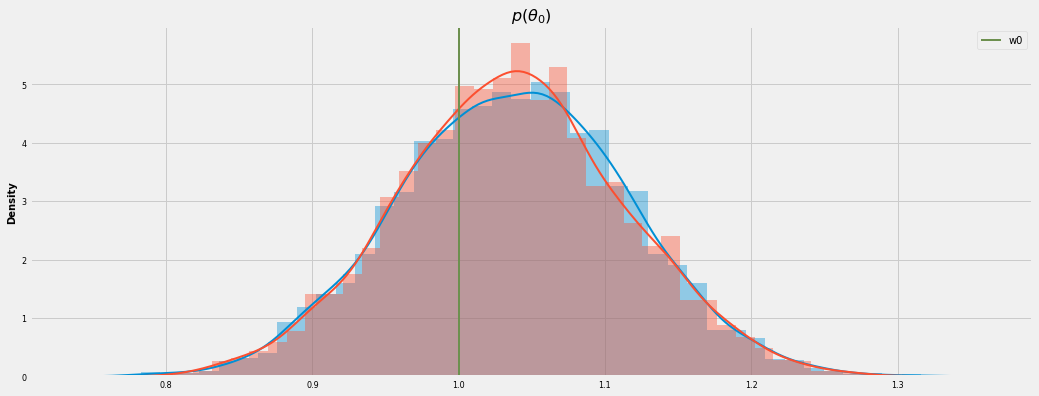

In [15]:
fig=plt.figure(figsize=(16,6))
ax=sns.distplot(trace.get_values('theta_0', burn=1000, combine=False)[0])
sns.distplot(trace.get_values('theta_0', burn=1000, combine=False)[1])
ax.axvline(w0, color=colors[3], label='w0')
plt.title(r'$p(\theta_0)$', fontsize=16)
plt.legend()
plt.show()

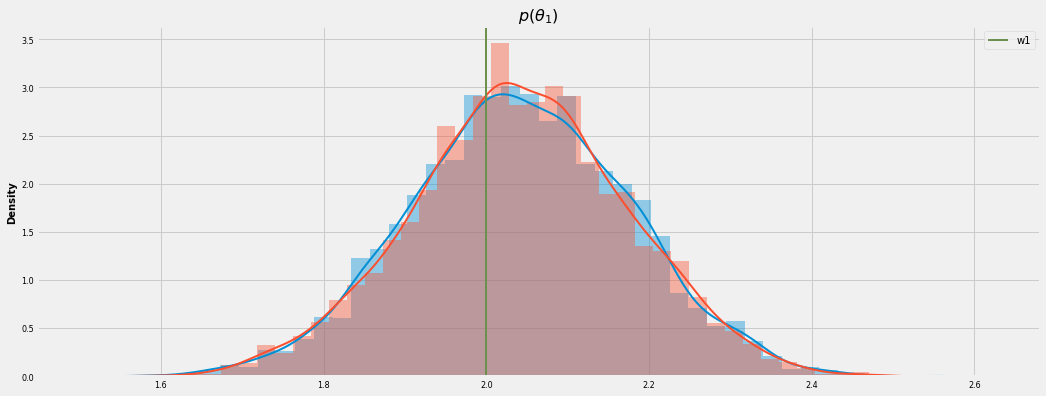

In [16]:
fig=plt.figure(figsize=(16,6))
ax=sns.distplot(trace.get_values('theta_1', burn=1000, combine=False)[0])
sns.distplot(trace.get_values('theta_1', burn=1000, combine=False)[1])
ax.axvline(w1, color=colors[3], label='w1')
plt.title(r'$p(\theta_1)$', fontsize=16)
plt.legend()
plt.show()

No handles with labels found to put in legend.


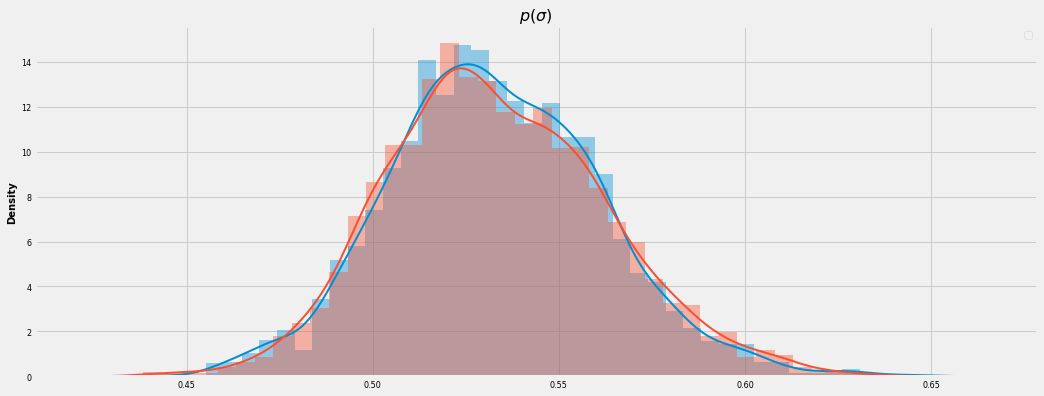

In [18]:
fig=plt.figure(figsize=(16,6))
ax=sns.distplot(trace.get_values('sigma', burn=1000, combine=False)[0])
sns.distplot(trace.get_values('sigma', burn=1000, combine=False)[1])
#ax.axvline(sigma, color=colors[3], label='$\sigma$')
plt.title(r'$p(\sigma)$', fontsize=16)
plt.legend()
plt.show()

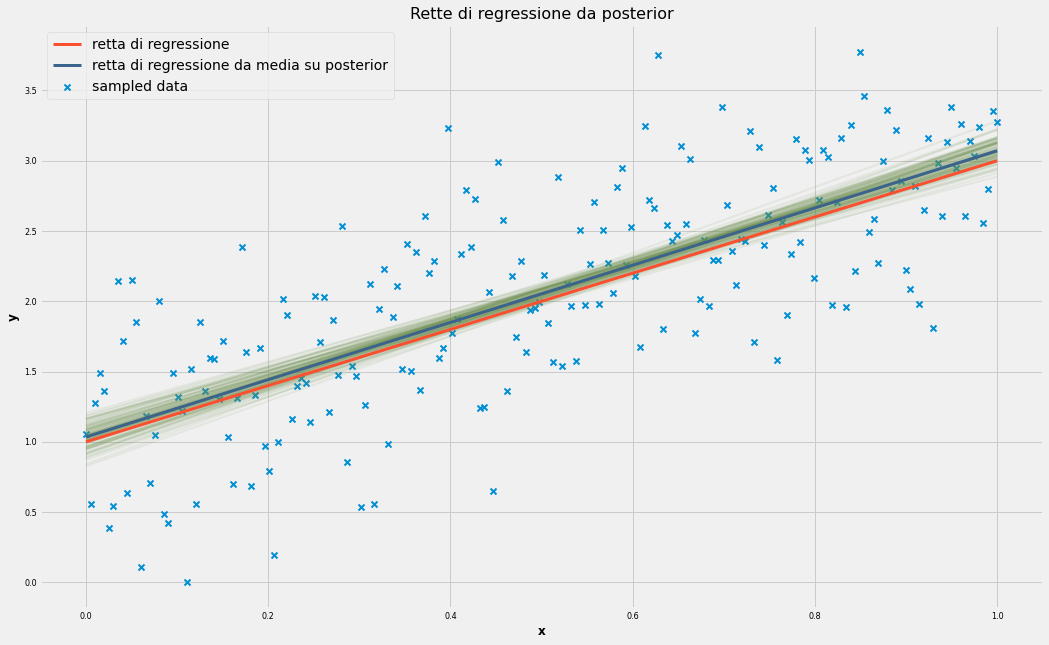

In [20]:
plt.figure(figsize=(16, 10))
plt.scatter(data['x'], data['y'], marker='x', color=colors[0],label='sampled data')
t0 = []
t1 = []
for i in range(100):
    ndx = np.random.randint(0, len(trace))
    theta_0, theta_1 = trace[ndx]['theta_0'], trace[ndx]['theta_1']
    t0.append(theta_0)
    t1.append(theta_1)
    p = theta_0+theta_1*data['x']
    plt.plot(x, p, c=colors[3], alpha=.1)
plt.plot(data['x'], regression_line, color=colors[1], label='retta di regressione', lw=3.)
theta_0_mean = np.array(t0).mean()
theta_1_mean = np.array(t1).mean()
plt.plot(data['x'], theta_0_mean+theta_1_mean*data['x'], color=colors[8], label='retta di regressione da media su posterior', lw=3.)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Rette di regressione da posterior', fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.show()

In [21]:
x_ = 3.9
x_test = np.array([0,x_])
x_shared.set_value(x_test)

In [22]:
ppc = pm.sample_posterior_predictive(trace, model=model, samples=1000)

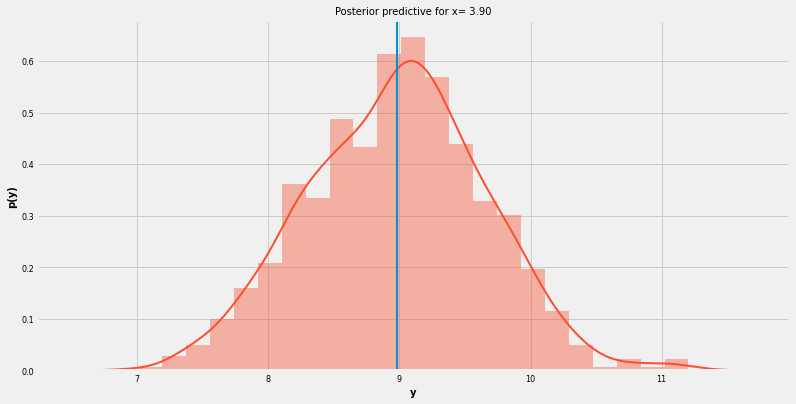

In [23]:
fig = plt.subplots(figsize=(12, 6))
ax = sns.distplot(ppc['y'][:,1], color=colors[1])
ax.axvline(ppc['y'][:,1].mean())
ax.set(title='Posterior predictive for x={0:5.2f}'.format(x_), xlabel='y', ylabel='p(y)');

![Diagramma modello regressione lineare t-Student.](assets/lin_regr_1.png)

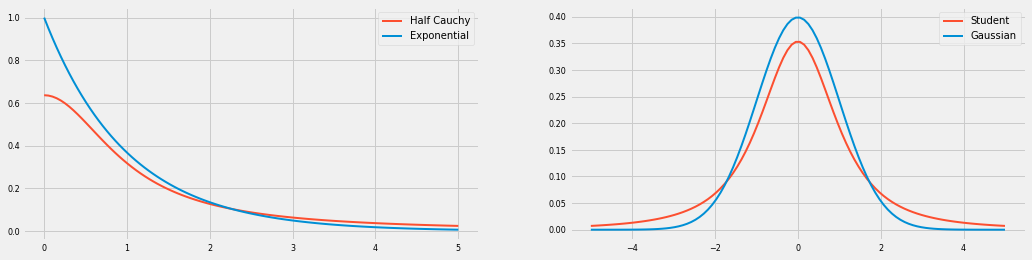

In [24]:
fig = plt.figure(figsize=(16, 4))
dist = stats.halfcauchy()
ax = fig.add_subplot(121)
xx = np.linspace(0,5, 100)
ax.plot(xx, dist.pdf(xx), color=colors[1], label='Half Cauchy')
ax.plot(xx, stats.expon.pdf(xx), label='Exponential')
plt.legend()
ax = fig.add_subplot(122)
dist1 = stats.t(2)
xx = np.linspace(-5,5, 100)
ax.plot(xx, dist1.pdf(xx), color=colors[1], label='Student')
ax.plot(xx, stats.norm.pdf(xx),label='Gaussian')
plt.legend()
plt.show()

In [24]:
with pm.Model() as model_1:
    # a priori
    sigma = pm.HalfCauchy('sigma', beta=1)
    theta_0 = pm.Normal('theta_0', mu=0, sd=20)
    theta_1 = pm.Normal('theta_1', mu=0, sd=20)
    # likelihood
    likelihood = pm.StudentT('y', mu=theta_0+theta_1*x, sd=sigma, nu=1.0, observed=y)
    trace_1 = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_1, theta_0, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 7000/7000 [00:11<00:00, 611.92draws/s]


In [35]:
pm.save_trace(trace_1, 'linregr1.trace', overwrite=True)
#with model_1:
#  trace_1 = pm.load_trace('linregr1.trace') 

'linregr1.trace'

<Figure size 1152x576 with 0 Axes>

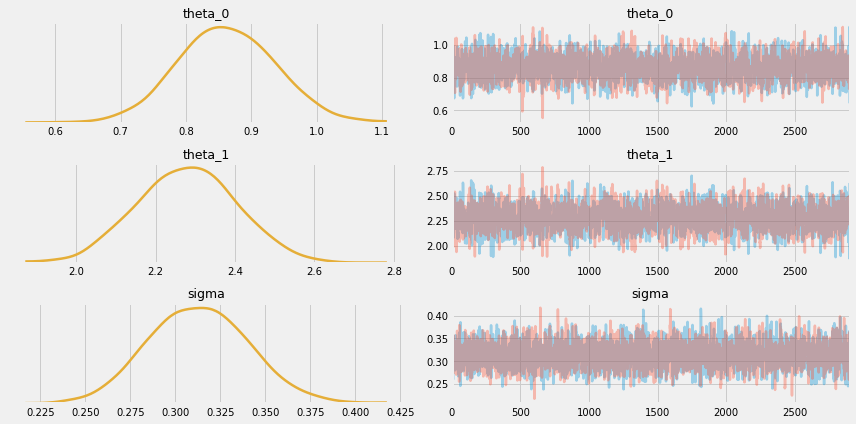

In [27]:
plt.figure(figsize=(16,8))
pm.traceplot(trace_1[100:], lines={'theta_0':w0, 'theta_1':w1}, combined=True)
plt.tight_layout()
plt.show()

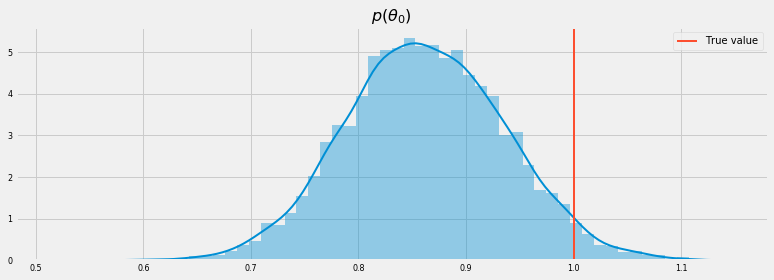

In [28]:
fig = plt.figure(figsize=(12,4))
ax = sns.distplot(trace_1['theta_0'], color=colors[0])
ax.axvline(w0, color=colors[1], label='True value')
plt.title(r'$p(\theta_0)$', fontsize=16)
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,4))
ax = sns.distplot(trace_1['theta_1'], color=colors[0])
ax.axvline(w1, color=colors[1], label='True value')
plt.title(r'$p(\theta_1)$', fontsize=16)
plt.legend()
plt.show()

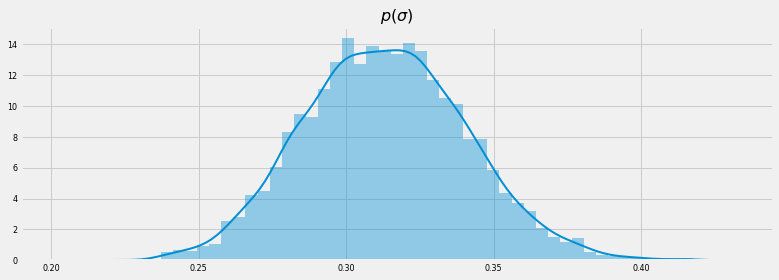

In [30]:
fig = plt.figure(figsize=(12,4))
ax = sns.distplot(trace_1['sigma'], color=colors[0])
plt.title(r'$p(\sigma)$', fontsize=16)
plt.show()

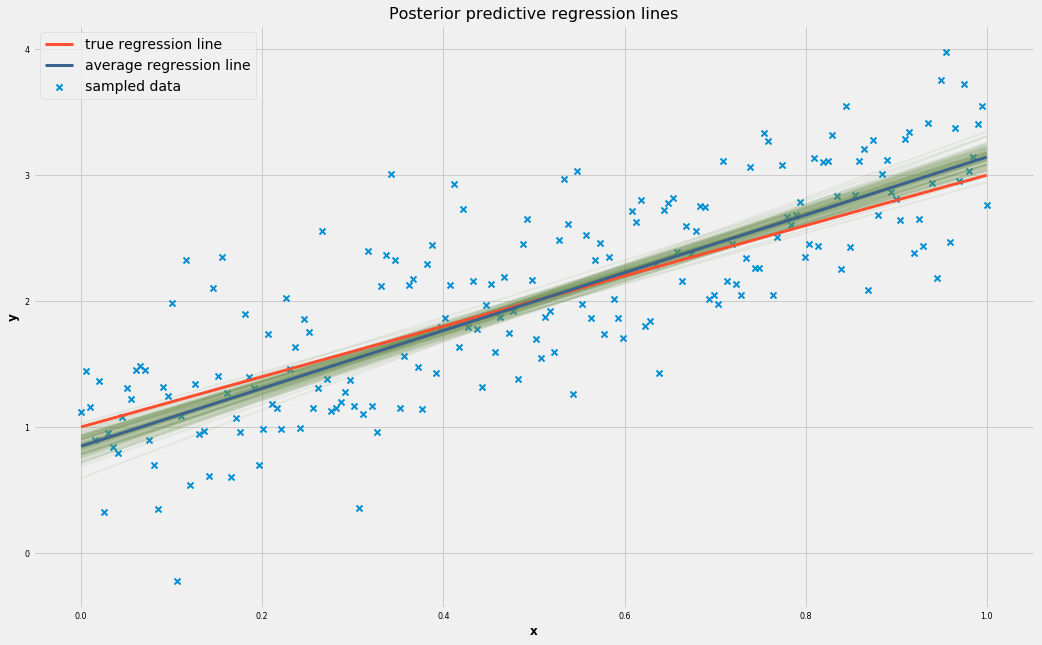

In [32]:
plt.figure(figsize=(16, 10))
plt.scatter(x, y, marker='x', color=colors[0],label='sampled data')
t0 = []
t1 = []
for i in range(100):
    ndx = np.random.randint(0, len(trace_1))
    theta_0, theta_1 = trace_1[ndx]['theta_0'], trace_1[ndx]['theta_1']
    t0.append(theta_0)
    t1.append(theta_1)
    p = theta_0+theta_1*x 
    plt.plot(x, p, c=colors[3], alpha=.1)
plt.plot(x, regression_line, color=colors[1], label='true regression line', lw=3.)
theta_0_mean = np.array(t0).mean()
theta_1_mean = np.array(t1).mean()
plt.plot(x, theta_0_mean+theta_1_mean*x, color=colors[8], label='average regression line', lw=3.)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Posterior predictive regression lines', fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.show()